In [44]:
from pulp import *
from lpVirtualOR import LBP
from __future__ import division
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [15]:
def pack(types, means, bins_n , bin_sizes):
    """
    FFD bin packing algorithm
    
    Returns the types of surgeries in bins
    """
    indices = np.argsort(means[types])[::-1] #Sort in Descending order
    sort_sizes = np.argsort(bin_sizes)[::-1]
    bins = [[] for _ in range(bins_n)]
    for i in indices:
        for s in sort_sizes:
            if np.sum(bins[s]) + means[types[i]] < bin_sizes[s]:
                bins[s].append(types[i])
                break
    return bins

In [26]:
def sample(amount, bounds):
    #Sample Data and creates cases.
    cases = {}
    case_means = []
    total = 1
    for n,b in zip(amount,bounds):
        for j in range(total,total+n):
            cases[j] = {}
            cases[j]["mean"] = int(np.ceil(sum(b)/2))
            cases[j]["dur"] = random.random_integers(b[0],b[1])
        total += n
    return cases

def simulation(cases,rooms_N,L, largest=True):
    """
    N : Number of cases of each kind to schedule
    T : Size of schedule in hours
    T_s : Size of schedule in units
    largeset: Use largest or smallest heuristics
    """
            
    #Sorts List and initializes 
    if(largest):
        sorted_list =[ j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["mean"],x[0]))] #sorted list
    else:
        sorted_list =[ j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["mean"],x[0]))][::-1] #sorted list
 
    rooms = [[] for _ in range(rooms_N)]
    rooms_cur = [0] * rooms_N
    
    # Packs the first cases in each room
    for i in range(rooms_N):
        if(not sorted_list):
            break
        c = sorted_list.pop()
        data = cases[c]
        data["app"] = 0
        data["start"]  = 0
        rooms[i].append(c)
        rooms_cur[i] = c   
        last_case = c
        while (cases[last_case]["app"] + cases[last_case]["mean"] < L and sorted_list):
            c = sorted_list.pop()
            data = cases[c]     
            data["app"] = cases[last_case]["app"] + cases[last_case]["mean"] 
            rooms[i].append(c)
            last_case = c #Get Last Case in rooms

    #Runs Simulation
    n = L
    while(sorted_list):
        for i in range(rooms_N):
            if(not rooms[i]):
                continue
            cur = rooms_cur[i]
            t = rooms[i].index(cur) #index of current case
            #Update current case estimates
            if(cases[cur]["start"] <= n):
                cur_data = cases[cur]
                #update end time
                cur_data["end"] = cur_data["start"] + cur_data["dur"]
                if(cur_data["end"] > n):
                    continue
                #update start time of next case
                if(t+1 != len(rooms[i])):
                    next_c = rooms[i][t+1]
                    cases[next_c]["start"] = max(cases[next_c]["app"],cur_data["end"])                
                    if(cur_data["end"] == n-L):
                        rooms_cur[i] = next_c

            #Calculates expected end of currently scheduled cases 
            expect = 0
            if(t+1 != len(rooms[i])):
                next_c = rooms[i][t+1]
                expect = cases[next_c]["start"]
                for k in rooms[i][t+1:]:
                    expect += cases[k]["mean"]
            else:
                expect = cases[cur]["end"]
                
            #Decides to schedule current or not
            if(expect <= n and sorted_list):
                c = sorted_list.pop()
                cases[c]["app"] = n
                rooms[i].append(c)

        #update for next time step
        n += 1
            
    #Finish the cases after L-step is overtime
    for i in range(rooms_N):
        if(not rooms[i]):
            continue
        cur = rooms_cur[i]
        t = rooms[i].index(cur) #index of current case
        #Update current case estimates
        for k in range(t,len(rooms[i])):
            cur = rooms[i][k]
            cur_data = cases[cur]
            #update end time
            cur_data["end"] = cur_data["start"] + cur_data["dur"]
            #update start time of next case
            if(k+1 != len(rooms[i])):
                next_c = rooms[i][k+1]
                cases[next_c]["start"] = max(cases[next_c]["app"],cur_data["end"])                
    
    return rooms

def calc_cost(cases, rooms,T_s):
    """
    Returns waiting_cost and idle_cost of schedule
    """
    wait_c = 0
    idle_c = 0
    overtime = 0
    for r in rooms:
        if(r):
            for i in range(len(r)-1):
                diff = cases[r[i+1]]["app"] - cases[r[i]]["end"] 
                wait_c += max(-diff,0)
                idle_c += max(diff,0)
            last = cases[r[-1]]
            overtime += max(0,last["end"] - T_s) 
    return wait_c,idle_c, overtime

In [94]:
#Initial Setup
N = 20 #Number of cases to schedule per types
T = 12 #Size of schedule in hours
dt = 4 # Units to divide each hour into
T_s = T * dt # Size of schedule in units
rooms_N = 2
L = 3

cases = sample([10,7,3],bounds = [(1,5),(3,9),(7,13)])
rooms = simulation(cases,rooms_N,L,False)
wait, idle, over = calc_cost(cases,rooms,T_s)
print "Waiting = {0} units, Idle = {1} units, over = {2}".format(wait,idle,over)

Waiting = 4 units, Idle = 3 units, over = 14


48


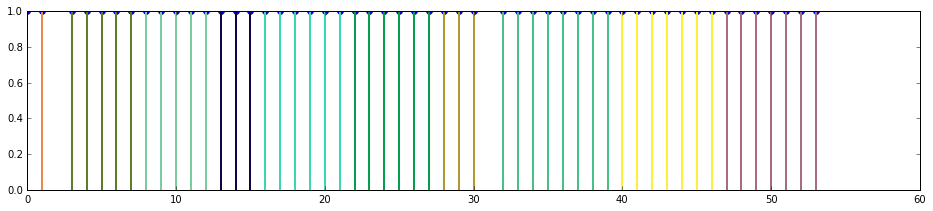

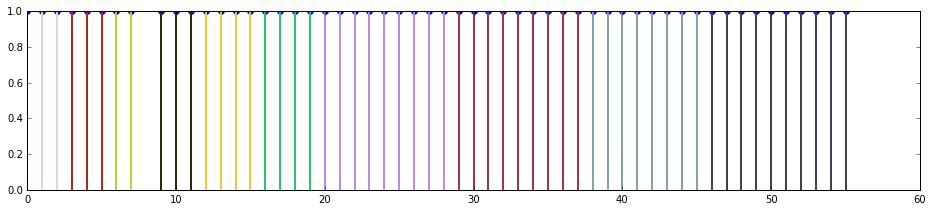

In [95]:
#Plotting Rooms
print T_s
for room in rooms:
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    for k in room:
        l = range(cases[k]["start"],cases[k]["end"])
        markerline, stemlines, baseline = plt.stem(l, np.ones(len(l)))
        c = color = random.rand(3,1)
        plt.setp(stemlines, linewidth=2, color=c)     # set stems to random colors
        plt.setp(markerline, 'markerfacecolor', 'b')

In [84]:
#### Kabir
# Run this part to get simulations and calculate costs for each simulation
T = 12 #Size of schedule in hours
dt = 4 # Units to divide each hour into
T_s = T * dt # Size of schedule in units
L_range = np.r_[3:300//15]
N = [10,7,3] #Number of cases to schedule per types
Total = np.sum(N) #Total number of Cases
rooms_N_range = np.r_[1:10]

runs = 5
costs_L = {}
costs_S = {}
for L in L_range:
    for rooms_N in rooms_N_range:
        #Large
        wait,idle,over = 0,0,0
        for _ in range(runs):
            cases = sample(N,bounds = [(1,5),(3,9),(7,13)])
            rooms = simulation(cases,rooms_N,L)
            c = calc_cost(cases,rooms,T_s)
            wait += c[0]
            idle += c[1]
            over += c[2]
        costs_L[(L,rooms_N)] = [wait/runs,idle/runs,over/runs]
        # Smalle
        wait,idle,over = 0,0,0
        for _ in range(runs):
            cases = sample(N,bounds = [(1,5),(3,9),(7,13)])
            rooms = simulation(cases,rooms_N,L)
            c = calc_cost(cases,rooms,T_s)
            wait += c[0]
            idle += c[1]
            over += c[2]
        costs_S[(L,rooms_N)] = [wait/runs,idle/runs,over/runs]

In [85]:
#Creates plots for every L value and sweeps the number of rooms
max_limit = np.max(np.r_[costs_L.values()])
pp = PdfPages('large_sweepRooms.pdf')
for L in L_range:
    c = sorted([x for x in costs_L.items() if x[0][0] == L], key = lambda x: x[0][1])
    size = np.array([x[0][1] for x in c])
    wait = np.array([x[1][0] for x in c])
    idle = np.array([x[1][1] for x in c])
    over = np.array([x[1][2] for x in c])
    
    #plt.figure()
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    
    plt.subplot(2,4,1)
    plt.title("Waiting time per case, large, L =  {0} | {1} min".format(L,L*60/dt))
    plt.ylabel("Time (min)")
    plt.xlabel("# of Rooms")
    plt.stem(size,wait*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,2)
    plt.title("Idle time per case, large, L =  {0} | {1} min".format(L,L*60/dt))
    plt.ylabel("Time (min)")
    plt.xlabel("# of Rooms")
    plt.stem(size,idle*60/dt * 1/Total)
    plt.ylim([0,max_limit])
    
    plt.subplot(2,4,3)
    plt.title("Overtime, large, L =  {0} | {1} min".format(L, L*60/dt))
    plt.xlabel("# of Rooms")
    plt.stem(size,over)
    plt.ylim([0,max_limit])
    
    plt.tight_layout()
        
    pp.savefig()
    plt.close()
pp.close()

In [86]:
#Creates plots for every L value and sweeps the number of rooms
max_limit = np.max(np.r_[costs_S.values()])
pp = PdfPages('small_sweepRooms.pdf')
for L in L_range:
    c = sorted([x for x in costs_S.items() if x[0][0] == L], key = lambda x: x[0][1])
    size = np.array([x[0][1] for x in c])
    wait = np.array([x[1][0] for x in c])
    idle = np.array([x[1][1] for x in c])
    over = np.array([x[1][2] for x in c])
    
    #plt.figure()
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    
    plt.subplot(2,4,1)
    plt.title("Waiting time per case,small , L =  {0} | {1} min".format(L,L*60/dt))
    plt.ylabel("Time (min)")
    plt.xlabel("# of Rooms")
    plt.stem(size,wait*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,2)
    plt.title("Idle time per case, small ,L =  {0} | {1} min".format(L,L*60/dt))
    plt.ylabel("Time (min)")
    plt.xlabel("# of Rooms")
    plt.stem(size,idle*60/dt * 1/Total)
    plt.ylim([0,max_limit])
    
    plt.subplot(2,4,3)
    plt.title("Overtime, small, L =  {0} | {1} min".format(L, L*60/dt))
    plt.xlabel("# of Rooms")
    plt.stem(size,over)
    plt.ylim([0,max_limit])
    
    plt.tight_layout()
        
    pp.savefig()
    plt.close()

pp.close()

In [87]:
#Creates plots for every number of rooms and sweeps the L value
max_limit = np.max(np.r_[costs_L.values()])
pp = PdfPages('large_sweepL.pdf')

for rooms_N in rooms_N_range:
    c = sorted([x for x in costs_L.items() if x[0][1] == rooms_N], key = lambda x: x[0][0])
    size = np.array([x[0][0] for x in c])
    wait = np.array([x[1][0] for x in c])
    idle = np.array([x[1][1] for x in c])
    over = np.array([x[1][2] for x in c])

    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    plt.subplot(2,4,1)
    plt.title("Waiting time,large, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,wait*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,2)
    plt.title("Idle time, large, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,idle*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,3)
    plt.title("Overtime, large, rooms_N =  {0}".format(rooms_N))
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,over)
    plt.ylim([0,max_limit])
    
    plt.tight_layout()
    
    pp.savefig()
    plt.close()

pp.close()
    #plt.savefig("./sweepL_N{0}.pdf".format(rooms_N))

In [88]:
#Creates plots for every number of rooms and sweeps the L value
max_limit = np.max(np.r_[costs_S.values()])
pp = PdfPages('small_sweepL.pdf')
for rooms_N in rooms_N_range:
    c = sorted([x for x in costs_S.items() if x[0][1] == rooms_N], key = lambda x: x[0][0])
    size = np.array([x[0][0] for x in c])
    wait = np.array([x[1][0] for x in c])
    idle = np.array([x[1][1] for x in c])
    over = np.array([x[1][2] for x in c])

    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    plt.subplot(2,4,1)
    plt.title("Waiting time, small, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,wait*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,2)
    plt.title("Idle time, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,idle*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(2,4,3)
    plt.title("Overtime, rooms_N =  {0}".format(rooms_N))
    plt.xlabel("L steps (min)")
    plt.stem(size*60/dt,over)
    plt.ylim([0,max_limit])
    
    plt.tight_layout()
    
    pp.savefig()
    plt.close()

pp.close()
    #plt.savefig("./sweepL_N{0}.pdf".format(rooms_N))

In [89]:
#Creates plots for every number of rooms and sweeps the L value
max_limit = np.max(np.r_[costs_S.values()])
pp_w = PdfPages('wait_sweepL.pdf')
pp_i = PdfPages('idle_sweepL.pdf')
pp_o = PdfPages('over_sweepL.pdf')

for rooms_N in rooms_N_range:
    c_S = sorted([x for x in costs_S.items() if x[0][1] == rooms_N], key = lambda x: x[0][0])
    c_L = sorted([x for x in costs_L.items() if x[0][1] == rooms_N], key = lambda x: x[0][0])

    size_S = np.array([x[0][0] for x in c_S])
    wait_S = np.array([x[1][0] for x in c_S])
    idle_S = np.array([x[1][1] for x in c_S])
    over_S = np.array([x[1][2] for x in c_S])

    size_L = np.array([x[0][0] for x in c_L])
    wait_L = np.array([x[1][0] for x in c_L])
    idle_L = np.array([x[1][1] for x in c_L])
    over_L = np.array([x[1][2] for x in c_L])
   
    #wait
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    plt.subplot(1,2,1)
    plt.title("Waiting time, small, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size_S*60/dt,wait_S*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(1,2,2)
    plt.title("Waiting time, large, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size_L*60/dt,wait_L*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.tight_layout()
    pp_w.savefig()
    plt.close()

    #idle
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    plt.subplot(1,2,1)
    plt.title("Idle time, small, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size_S*60/dt,idle_S*60/dt * 1/Total)
    plt.ylim([0,max_limit])

    plt.subplot(1,2,2)
    plt.title("Idle time, large, rooms_N =  {0}".format(rooms_N))
    plt.ylabel("Time (minutes)")
    plt.xlabel("L steps (min)")
    plt.stem(size_L*60/dt,idle_L*60/dt * 1/Total)
    plt.ylim([0,max_limit])
    
    plt.tight_layout()
    pp_i.savefig()
    plt.close()
    #over
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    plt.subplot(1,2,1)
    plt.title("Overtime , small, rooms_N =  {0}".format(rooms_N))
    plt.xlabel("L steps (min)")
    plt.stem(size_S*60/dt,over_S )
    plt.ylim([0,max_limit])
    
    plt.subplot(1,2,2)
    plt.title("Overtime , rooms_N =  {0}".format(rooms_N))
    plt.xlabel("L steps (min)")
    plt.stem(size_L*60/dt,over_L)
    plt.ylim([0,max_limit])
    plt.tight_layout()
    
    plt.tight_layout()
    
    pp_o.savefig()
    plt.close()

pp_w.close()
pp_i.close()
pp_o.close()
    #plt.savefig("./sweepL_N{0}.pdf".format(rooms_N))

In [ ]:
#LBP scheduler
durations = [x["mean"] for x in cases.values()]
#LBP(durations,9)